# Macroprudential Policy and the Housing Market
This notebook solves and simulates the Heterogenous Agent Housing Market (HAH) model and produces the output contained in my Master's thesis. 

**Dependencies:**

The code structure builds upon the framework developed by Jeppe Druedahl & Co. in the [NumEconCopenhagen Project](https://github.com/NumEconCopenhagen)

Packages required for running the notebook are:
- [ConSav](https://pypi.org/project/ConSav/)
- [EconModel](https://pypi.org/project/EconModel/)
- [matplotlib](https://pypi.org/project/matplotlib/)
- [numpy](https://pypi.org/project/numpy/)
- [numba](https://pypi.org/project/numba/)
- [pandas](https://pypi.org/project/pandas/)

## 0 Preparations

### 0.0 Import packages and ModelClass

In [37]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import pandas as pd

nb.set_num_threads(4) # set equal to the number of cores in your CPU

from HAHModel import HAHModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 0.1 Import data for equivalence scale and life cycle income profile

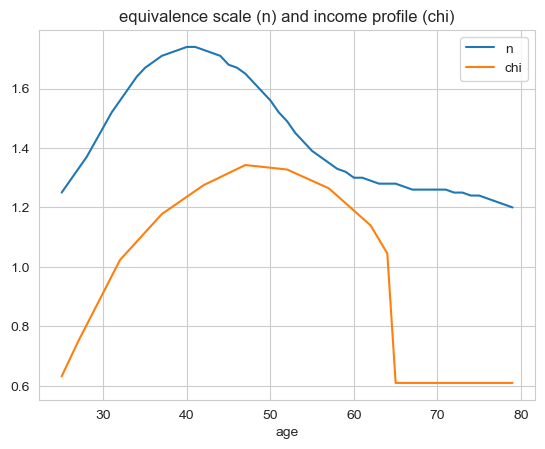

In [38]:
#wd = '/Users/Christian/Dropbox/KU - Polit/KA/Thesis'
data = pd.read_excel(
    io='equiscale.xlsx',
    sheet_name='output')

# adjust income profile and slice
Tr = 65-25 # retirement age - par.Tmin
pension = 0.75 # adjustment for drop in income at retirement

data['chi'] = data['chi'].interpolate(method='linear')+0.1 # quick fix to get mean ca. one
data = data.iloc[3:-3,:]
data['chi'].iloc[Tr:] = pension*np.mean(data['chi'].iloc[Tr:])

## extract arrays
n = data['n'].to_numpy(dtype='float')
chi = data['chi'].to_numpy(dtype='float') 

# plot data
data.plot(x='t_plus_Tmin',y=['n','chi'])
plt.xlabel('age')
plt.title('equivalence scale (n) and income profile (chi)');

### 0.2 Import arrays for comparing model output with data

In [94]:
c_data = pd.read_excel(
    io='LifeCycleData.xlsx',
    sheet_name='ConsumptionOutput')
c_data = c_data.to_numpy()

nw_data = pd.read_excel(
    io='LifeCycleData.xlsx',
    sheet_name='NetWealthOutput')
nw_data = nw_data.to_numpy()

hexp_data = pd.read_excel(
    io='LifeCycleData.xlsx',
    sheet_name='HexpOutput')
hexp_data = hexp_data.to_numpy()

ho_data = pd.read_excel(
    io='LifeCycleData.xlsx',
    sheet_name='HoOutput')
ho_data = ho_data.to_numpy()

d_data = pd.read_excel(
    io='LifeCycleData.xlsx',
    sheet_name='MortgageOutput')
d_data = d_data.to_numpy()

## 1 Baseline model

In [42]:
# initialise an instance of baseline model
model_baseline = HAHModelClass(
    name='baseline',
    par={
        'zeta':10, # increased utility cost of default
        'kappa':0.0,
        'thetab':300,
        'K':10, 
        'omega_ltv':0.9,  
        'C_buy':0.0,   # JEJA sets the buyer cost to zero 
        'chi':chi,
        'n':n,
        'do_print':True,
        'include_unemp':False
        })

model_baseline.precompile_numba() # solve model with very coarse grids --> speed gains
model_baseline.solve()
model_baseline.simulate()
#model_baseline.save()

 t = 3 solved in 55.5 secs
 t = 2 solved in 46.3 secs
 t = 1 solved in 0.0 secs
 t = 0 solved in 0.0 secs
 total precomputation time  = 64.2 secs
 total stay-time  = 8.6 secs
 total ref-time   = 11.0 secs
 total buy-time   = 9.2 secs
 total rent-time   = 8.8 secs
 full model solved in = 101.8 secs
model simulated in 64.0 secs
numba precompiled in 169.4 secs
 last period bequest computed in 0.0 secs
 solved stayer problem in 0.1 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 54 solved in 0.1 secs
 v_bar and q computed in 1.0 secs
 solved stayer problem in 0.1 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 53 solved in 1.1 secs
 v_bar and q computed in 1.1 secs
 solved stayer problem in 0.3 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 52 solved in 1.5 secs
 v_bar and q computed i

### 1.0 Decision Functions

In [21]:
import figs
#figs.decision_functions(model_baseline)

### 1.1 Life Cycle Behaviour

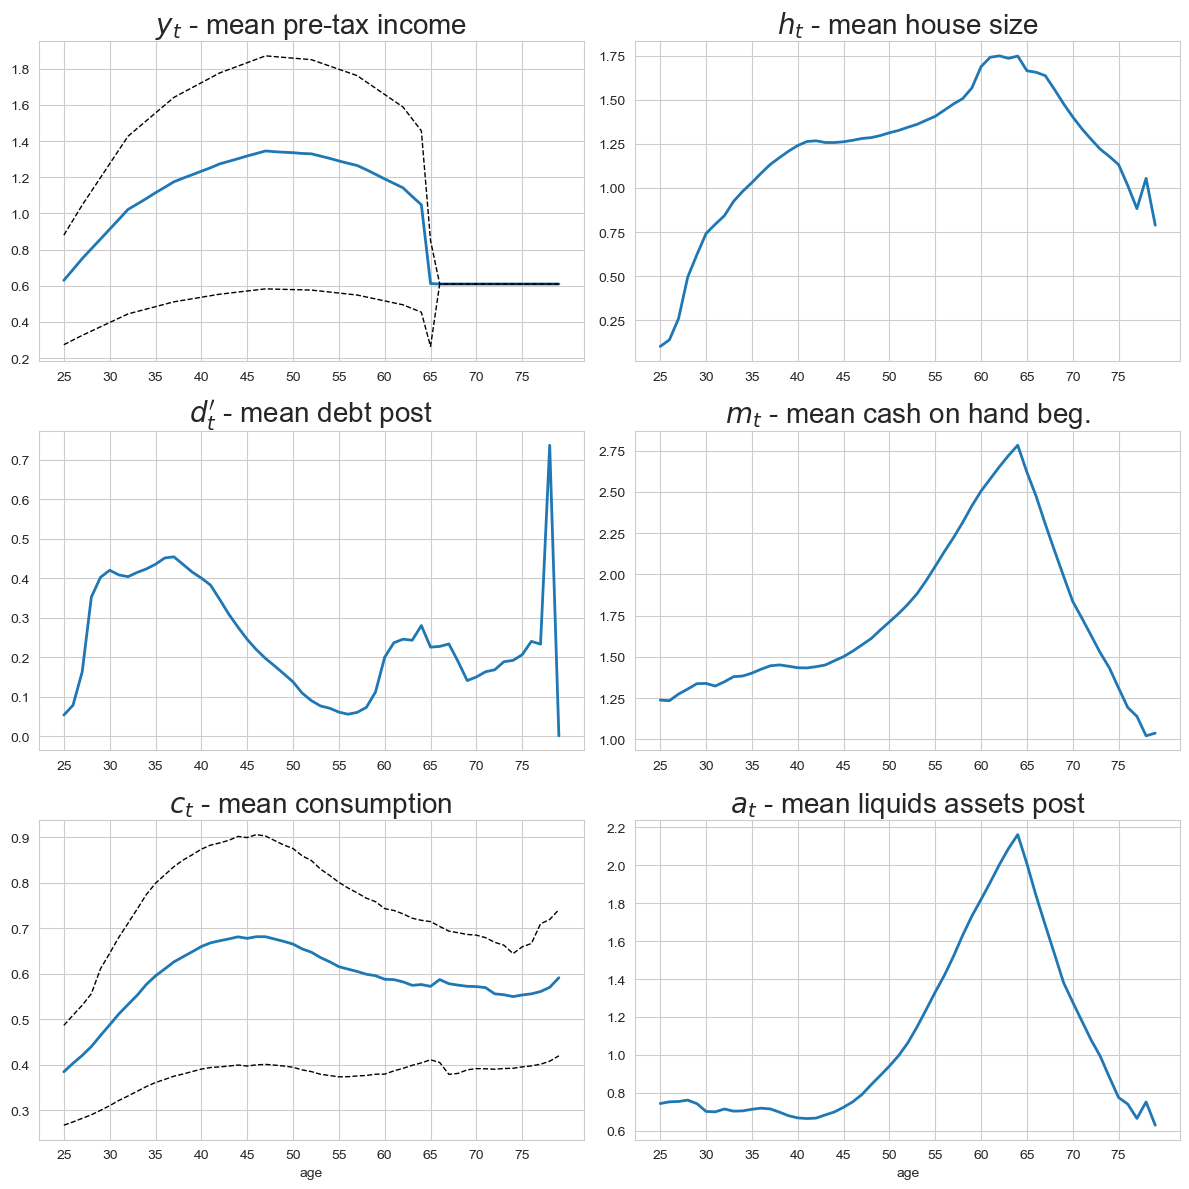

In [43]:
import figs

# average behaviour over the life cycle
figs.lifecycle_full(model_baseline)

### 1.2 Compare with data

In [93]:
#figs.lifecycle_consav(model_baseline,c_data,nw_data)

In [92]:
#figs.lifecycle_housing(model_baseline,ho_data,hexp_data)

In [91]:
#figs.lifecycle_mortgage(model_baseline,d_data)

### 1.3 Validate simulation

In [44]:
# unpack
sim = model_baseline.sim 
par = model_baseline.par

# validate consumption decision
I = sim.c < 0

print(f'there are {np.sum(I)} cases of negative consumption, consider solving the model on finer grids.') 
if np.sum(I) > 0:
    print(f'ref accounts for {np.sum(I*(sim.discrete==1))} and buy for {np.sum(I*(sim.discrete==2))}.')
    print(f'stay accounts for {np.sum(I*(sim.discrete==0))} and rent for {np.sum(I*(sim.discrete==3))}')
    print(f'the share of negative consumption cases is {np.sum(I)/(par.simN*par.T)}')
    print()
    print('negative simulated consumption occurs in periods:')
    print(np.unique(np.where(sim.c < 0)[0],return_counts=True)[0])
    print('and cases per period are:')
    print(np.unique(np.where(sim.c < 0)[0],return_counts=True)[1])

there are 372 cases of negative consumption, consider solving the model on finer grids.
ref accounts for 114 and buy for 258.
stay accounts for 0 and rent for 0
the share of negative consumption cases is 6.763636363636364e-05

negative simulated consumption occurs in periods:
[52 53]
and cases per period are:
[ 66 306]


taxes to labour income is 0.3551
median pre tax income is 0.6097
mean property tax is 0.0118
mean pre tax income is 1.0058


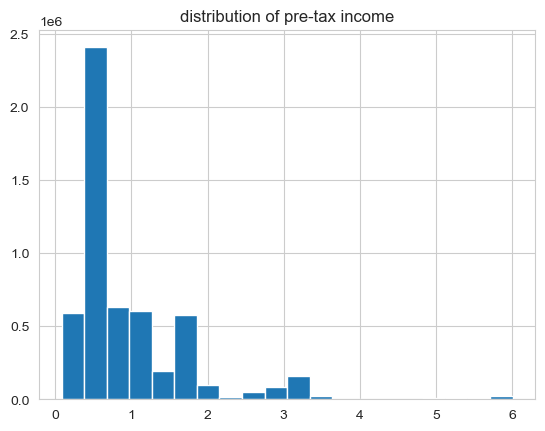

In [45]:
#print(np.unique(sim.Td_prime[52],return_counts=True))
#print(f'{(np.unique(sim.d[40],return_counts=True)[0])}')
#print(f'{np.unique(sim.d[40],return_counts=True)[1]}')
y = sim.y
inc_tax = sim.inc_tax
prop_tax = sim.prop_tax
tax_to_inc = np.sum(inc_tax)/np.sum(y)
print(f'taxes to labour income is {tax_to_inc:.4f}')
print(f'median pre tax income is {np.median(y):.4f}')
print(f'mean property tax is {np.mean(prop_tax):.4f}')
print(f'mean pre tax income is {np.mean(y):.4f}')

plt.hist(y.flatten(),bins=20)
plt.title('distribution of pre-tax income');


the distribution of house choices is:
[0.    1.704 2.268 3.012 4.008 5.328 7.092]
[2972680 1287184  420068  189279  488383   76372   66034]

the distribution of rental choices is:
[0.    1.284 1.704 2.268]
[2620532 2436649  314600  128219]

mean homeowner share is 0.4765


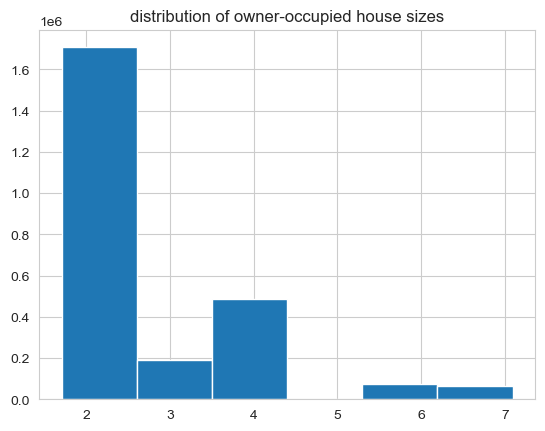

In [46]:
# validate housing and rental decisions
print('the distribution of house choices is:')
print(np.unique(sim.h,return_counts=True)[0])
print(np.unique(sim.h,return_counts=True)[1])
print()
print('the distribution of rental choices is:')
print(np.unique(sim.h_tilde,return_counts=True)[0])
print(np.unique(sim.h_tilde,return_counts=True)[1])
print()
print(f'mean homeowner share is {np.unique(sim.h_tilde,return_counts=True)[1][0]/(par.T*par.simN):.4f}')
h_bool = sim.h > 0 
h = sim.h[h_bool]
plt.hist(h.flatten(),bins=6)
plt.title('distribution of owner-occupied house sizes');

In [72]:
# validate mortage decision
D = sim.d > 0 # take mortgage?
Dp = sim.d_prime > 0
DA = sim.Tda_prime > 0 # choose deferred amortisation?
t_mat = np.outer(np.arange(par.T),np.ones(par.simN))
D_org = Dp*(sim.Td_prime - (par.Td_bar) == t_mat) # boolean for loan originations

print(f'average mortgage size at origination is {np.mean(sim.d_prime[D_org]):.4f}')
print(f'sum of outstanding mortgage balances are {np.sum(sim.d):.4f}')
#print(f'periods where mortgages are issued are {np.where(np.sum(sim.d_prime,axis=1)>0)[0]}')

average mortgage size at origination is 1.4440
sum of outstanding mortgage balances are 1220930.8248


In [48]:
# validate impact of financial regulation
ltv_denom = sim.h_prime[D_org]
ltv_num = sim.d_prime[D_org]
dti_denom = sim.y[D_org]
ltvs = ltv_num/ltv_denom
dtis = ltv_num/dti_denom

print('the distribution of DA periods is:')
print(np.unique(sim.Tda,return_counts=True)[0])
print(np.unique(sim.Tda,return_counts=True)[1])
print(f'and the share of DA mortgages at origination is {np.sum(DA[D_org])/np.sum(Dp[D_org]):.4f}')
print()
print(f'mean LTV is {np.mean(ltvs):.4f} and mean DTI is {np.mean(dtis):.4f} at mortgage origination')

the distribution of DA periods is:
[0. 1. 2. 3. 4. 5. 6. 7. 8.]
[5328615   18373   19227   22345   27681   35799   40294    3754    3912]
and the share of DA mortgages at origination is 1.0000

mean LTV is 0.7250 and mean DTI is 0.8897 at mortgage origination


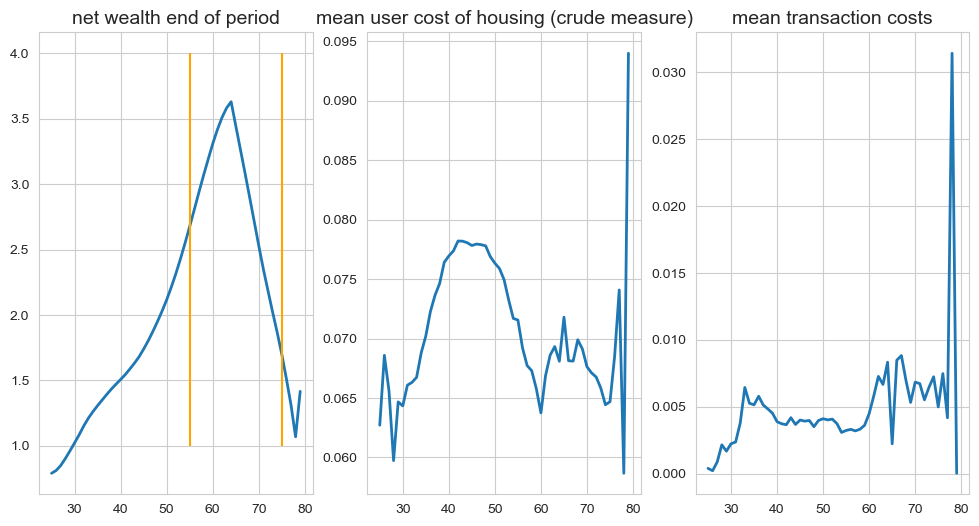

In [49]:
figs.nw_and_tc(model_baseline)

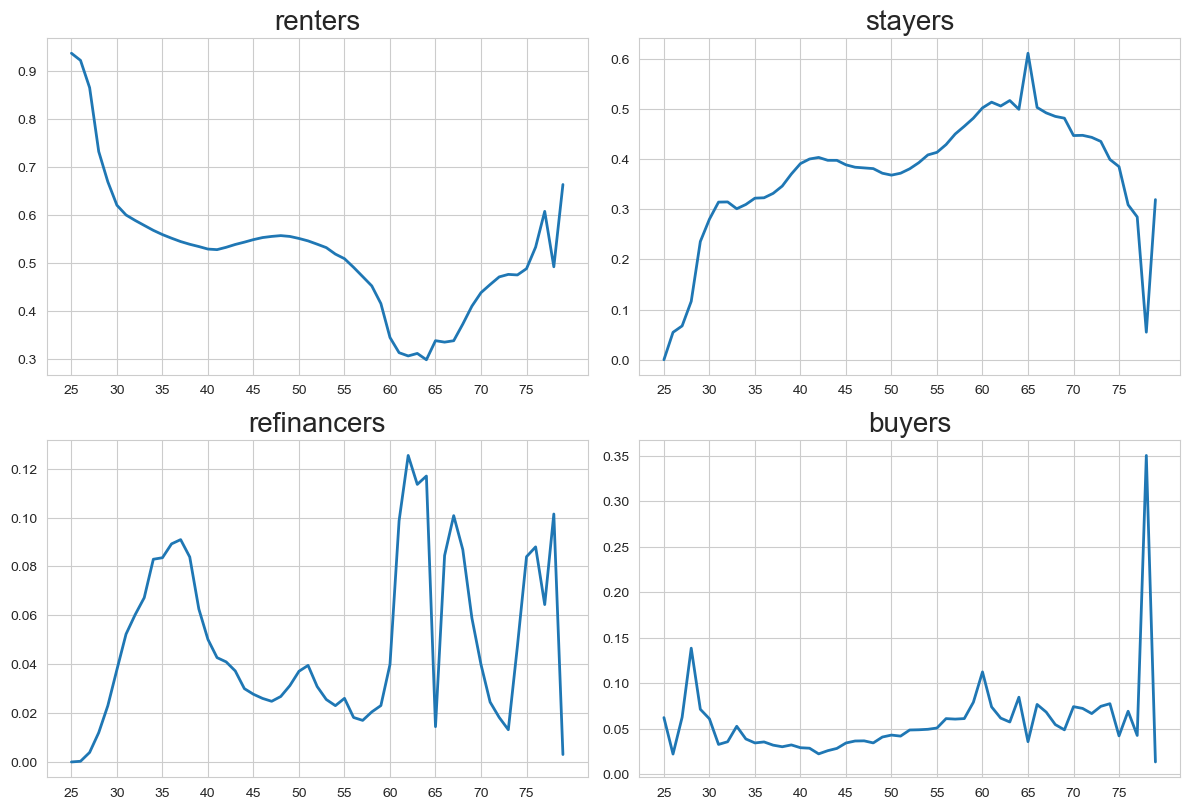

In [50]:
figs.homeownership(model_baseline)

#### inspect the life cycle profile of a given household

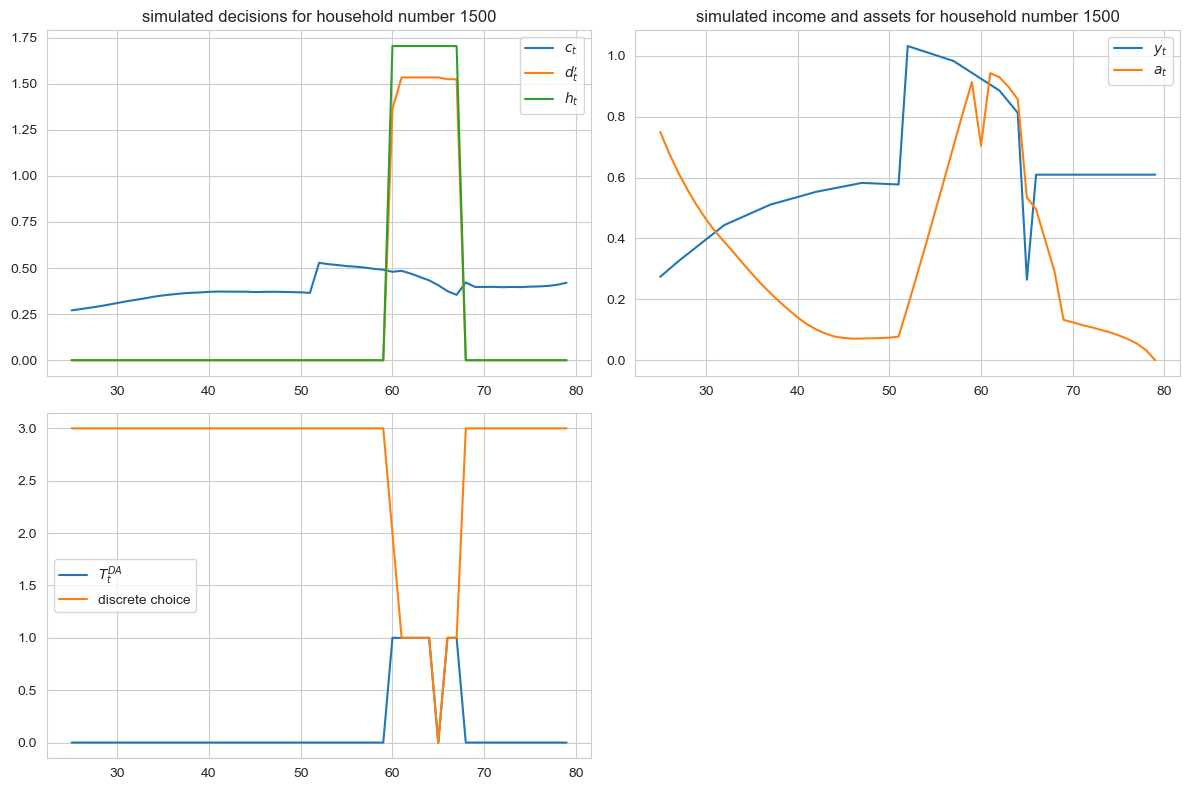

In [52]:
# settings
hh_no = 1_500
x_ax = np.arange(par.T)+par.Tmin

# simulation output
d = sim.d[:,hh_no]
dp = sim.d_prime[:,hh_no]
y = sim.y[:,hh_no]
hp = sim.h_prime[:,hh_no]
h = sim.h[:,hh_no]
discrete = sim.discrete[:,hh_no]
DA = sim.Tda_prime[:,hh_no]
a = sim.a[:,hh_no]
m = sim.m[:,hh_no]
c = sim.c[:,hh_no]
i_y = sim.i_y[:,hh_no]

# plots
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(2,2,1)
ax1.plot(x_ax,c,label='$c_t$')
ax1.plot(x_ax,dp,label='$d^{\prime}_t$')
ax1.plot(x_ax,hp,label='$h_t$')
ax1.legend()
ax1.set_title(f'simulated decisions for household number {hh_no}')

ax2 = fig.add_subplot(2,2,2)
ax2.plot(x_ax,y,label='$y_t$')
ax2.plot(x_ax,a,label='$a_t$')
ax2.legend()
ax2.set_title(f'simulated income and assets for household number {hh_no}')

ax3 = fig.add_subplot(2,2,3)
ax3.plot(x_ax,DA,label='$T^{DA}_t$')
ax3.plot(x_ax,discrete,label='discrete choice')
ax3.legend()

#ax4 = fig.add_subplot(2,2,4)
#ax4.plot(x_ax,c,label='consumption')
fig.tight_layout()
plt.show();


In [53]:
print(f'max initial assets {np.max(sim.a[0])}')
print(f'max final assets is {np.max(sim.a[-1])} and is held by consumer {np.argmax(sim.a[-1])}')
print(f'max assets {np.max(sim.a)}')
print(f'max pre-tax income {np.max(sim.y)}')
print(f'max bop cash-on-hand {np.max(sim.m)}')
print(f'max mortgage balance {np.max(sim.d)}')
np.sum(sim.a > 0.5*np.max(sim.a))/(par.T*par.simN)

max initial assets 4.292542841408836
max final assets is 29.749106444382555 and is held by consumer 27074
max assets 45.617658589014084
max pre-tax income 6.005803968309933
max bop cash-on-hand 48.08522466767183
max mortgage balance 4.7952


0.0034685454545454546

In [182]:
par.grid_w

array([0.13517269, 0.24220029, 0.43397063, 0.77758169, 1.39325853,
       2.49641853, 4.4730431 ])

### Loop to match bequest level with initial wealth

In [91]:
# a. unpack
par = model_baseline.par
sim = model_baseline.sim 

# find mean bequest for initial guess
import trans
from EconModel import jit
with jit(model_baseline) as model:
    par = model.par
    ab_tot = 0
    t = par.T-1
    for n in range(par.simN):
        ab_tot += trans.ab_plus_func(
            sim.a[t,n],
            sim.d_prime[t,n],
            sim.Tda_prime[t,n],
            sim.h_prime[t,n],
            par)
    ab_mean = ab_tot/par.simN
print(f'initial wealth is {np.sum(sim.a0):.4f}')
print(f'total bequest is {ab_tot:.4f}')
print(f'mean bequest is {ab_mean:.4f}')
print(f'average hh pre-tax income is {np.mean(sim.y)*670_000:.4f}')

initial wealth is 90849.0092
total bequest is 74917.9161
mean bequest is 0.7492
average hh pre-tax income is 673892.5160


In [92]:
# agggregate housing demand
H_d = np.sum(sim.h) + np.sum(sim.h_tilde)
print(f'aggregate housing demand for purchase and rental is {H_d:.4f}')

aggregate housing demand for purchase and rental is 10516206.3240


In [93]:
import steady_state
steady_state.bequest_loop(model_baseline,ab_mean)

iteration = 1, discrepancy = 0.213642
iteration = 2, discrepancy = 0.095395
iteration = 3, discrepancy = 0.042206
iteration = 4, discrepancy = 0.018708
iteration = 5, discrepancy = 0.008488
iteration = 6, discrepancy = 0.003839
iteration = 7, discrepancy = 0.001675
iteration = 8, discrepancy = 0.000823
iteration = 9, discrepancy = 0.000331
iteration = 10, discrepancy = 0.000120
iteration = 11, discrepancy = 0.000072
iteration = 12, discrepancy = 0.000030
iteration = 13, discrepancy = 0.000015
iteration = 14, discrepancy = 0.000007
iteration = 15, discrepancy = 0.000003
iteration = 16, discrepancy = 0.000001
iteration = 17, discrepancy = 0.000001
convergence achieved in 17 simulations, mean bequest = 0.315715


### Test solving the household problem for a few periods

In [ ]:
import HHproblems as hhp
from EconModel import jit

par = model_baseline.par

t = par.T-1
Td_len = np.fmin(t+2,par.Td_shape)
Tda_len = np.fmin(par.Tda_bar,par.T-t+1)

with jit(model_baseline) as model: 
    sol = model.sol
    par = model.par
    hhp.last_period_v_bar_q(t,sol,par)
    assert np.all((sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.q[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.q[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t                  
    print('post decision is done')
    hhp.solve_stay(t,sol,par)
    assert np.all((sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    print('stay is done')
    hhp.solve_ref_fast(t,sol,par)
    assert np.all((sol.c_ref_fast[t] >= 0) & (np.isnan(sol.c_ref_fast[t]) == False)), t
    assert np.all((sol.d_prime_ref_fast[t] >= 0) & (np.isnan(sol.d_prime_ref_fast[t]) == False)), t
    assert np.all((sol.inv_v_ref_fast[t] >= 0) & (np.isnan(sol.inv_v_ref_fast[t]) == False)), t
    print('refinance is done')
    hhp.solve_buy_fast(t,sol,par)
    assert np.all((sol.c_buy_fast[t] >= 0) & (np.isnan(sol.c_buy_fast[t]) == False)), t
    assert np.all((sol.d_prime_buy_fast[t] >= 0) & (np.isnan(sol.d_prime_buy_fast[t]) == False)), t
    assert np.all((sol.inv_v_buy_fast[t] >= 0) & (np.isnan(sol.inv_v_buy_fast[t]) == False)), t                
    print('buy is done')
    hhp.solve_rent(t,sol,par)
    assert np.all((sol.c_rent[t] >= 0) & (np.isnan(sol.c_rent[t]) == False))
    assert np.all((sol.inv_v_rent[t] >= 0) & (np.isnan(sol.inv_v_rent[t]) == False))            
    print('rent is done')
    t = t-1
    print(f'start solving t={t}')
    #hhp.postdecision_compute_v_bar_q.py_func(t,sol,par)
    hhp.postdecision_compute_v_bar_q_rent(t,sol,par)
    hhp.postdecision_compute_v_bar_q_own(t,sol,par)
    assert np.all((sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.q[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.q[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t                  
    print('post decision is done')
    hhp.solve_stay(t,sol,par)
    assert np.all((sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    print('stay is done')
    hhp.solve_ref_fast(t,sol,par)
    assert np.all((sol.c_ref_fast[t] >= 0) & (np.isnan(sol.c_ref_fast[t]) == False)), t
    assert np.all((sol.d_prime_ref_fast[t] >= 0) & (np.isnan(sol.d_prime_ref_fast[t]) == False)), t
    assert np.all((sol.inv_v_ref_fast[t] >= 0) & (np.isnan(sol.inv_v_ref_fast[t]) == False)), t
    print('refinance fast is done')
    hhp.solve_buy_fast(t,sol,par)
    assert np.all((sol.c_buy_fast[t] >= 0) & (np.isnan(sol.c_buy_fast[t]) == False)), t
    assert np.all((sol.d_prime_buy_fast[t] >= 0) & (np.isnan(sol.d_prime_buy_fast[t]) == False)), t
    assert np.all((sol.inv_v_buy_fast[t] >= 0) & (np.isnan(sol.inv_v_buy_fast[t]) == False)), t                
    print('buy fast is done')
    hhp.solve_rent(t,sol,par)
    assert np.all((sol.c_rent[t] >= 0) & (np.isnan(sol.c_rent[t]) == False))
    assert np.all((sol.inv_v_rent[t] >= 0) & (np.isnan(sol.inv_v_rent[t]) == False))            
    print('rent is done')

### Sanity checks

In [ ]:
# check NaNs in relevant part of sol.inv_v_bar

#nan_mat_v = np.argwhere(np.isnan(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:]))
#print(f'size of q at t={t} is {sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {nan_mat_v.shape[0]} NaN entries')
#print(f'the nan indices are {nan_mat_v}')
#
## check zero or negative entries in relevant part of sol.inv_v_bar
#zero_mat_v= np.argwhere(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:] <= 0)
#print(f'size of c_endo at t={t} with Tda in 0,1,2 is {sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {zero_mat_v.shape[0]} zero or negative entries')
#print(f'the zero indices/negative are {zero_mat_v}')

par = model_baseline.par
sol = model_baseline.sol

t = 21
Td_len = np.fmin(t+2,par.Td_shape)
Tda_len = np.fmin(par.Tda_bar,par.T-t+1)

#nan_mat_q = np.argwhere(np.isnan(sol.q[t,6,0:3,0:Td_len,0:Tda_len,4:,:]))
#print(f'size of q at t={t} is {sol.q[t,6,0:3,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {nan_mat_q.shape[0]} NaN entries')
#print(f'the nan indices are {nan_mat_q}')

# check zero or negative entries in relevant part of sol.inv_v_bar
zero_mat_q= np.argwhere(sol.q[t,:,:,0:Td_len,0:Tda_len,:,:] <= 0)
print(f'size of q at t={t} is {sol.q[t,6,0:3,0:Td_len,0:Tda_len,4:,9].size}')
print(f'there are {zero_mat_q.shape[0]} zero or negative entries')
print(f'the zero indices/negative are {zero_mat_q}')


In [ ]:
from EconModel import jit
import utility

# a. unpack
with jit(model_baseline) as model:
    par = model_baseline.par
    sim = model_baseline.sim 

# b. check utility function
c = 1
h = 1
move = 0 
rent = 1
t = 20
n = par.n[t]
nu = 0.4
alpha = 1.1
s = (1-rent)*h/n + par.phi*rent*h/n
print(f' rent utility is {utility.func(c,h,move,rent,t,par)}')
print(f' own utility is {utility.func(c,h,move,0,t,par)}')
print(f' diff is {utility.func(c,h,move,rent,t,par)-utility.func(c,h,move,0,t,par)}')
print(f' s ={s}')
print(f' u(s) ={nu/(1-alpha)*s**(1-alpha)}')
print(f' u(h) ={nu/(1-alpha)*(h/n)**(1-alpha)}')
print(f' diff is {nu/(1-alpha)*s**(1-alpha)-nu/(1-alpha)*(h/n)**(1-alpha)}')

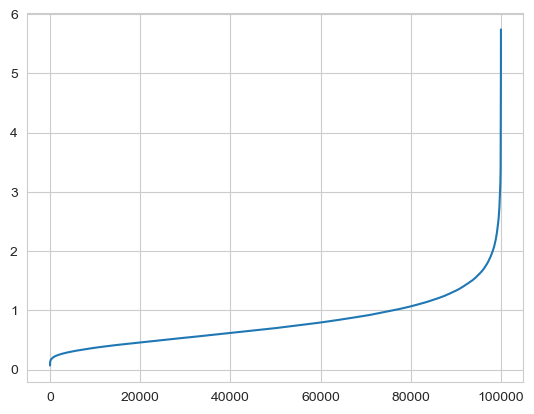

In [51]:
plt.plot(np.sort(sim.a0));